In [1]:
import sys
sys.path.append("../input/timmeffnetv2")

In [2]:
! pip install -q pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [3]:
import platform
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import random
import os

import torch
import timm
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR 
from warmup_scheduler import GradualWarmupScheduler
import albumentations

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations import *
from albumentations.pytorch import ToTensorV2

import warnings
warnings.simplefilter('ignore')

In [4]:
train_labels = pd.read_csv('../input/siim-1024x-dataset/train_1024x_6054images.csv')
del train_labels['index']
targets = train_labels[['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']]
targets = pd.DataFrame(targets.values.argmax(1))

In [5]:
image_size = 224
seed = 9999
warmup_epo = 1
init_lr = 1e-4/3
batch_size = 64
valid_batch_size = 64
n_epochs = 25
warmup_factor = 10
num_workers = 8

use_amp = True
early_stop = 5


In [6]:
class Config:
    N_SPLITS = 5
    model_name = 'vit_base_patch16_224_in21k'
    resize = (224, 224)
    TRAIN_BS = 64
    VALID_BS = 64
    num_workers = 8
    NB_EPOCHS = 25

In [7]:
def plotFromFoldScores(score_dict, colors=None):
    if colors is None:
        colors = ['r', 'g', 'y', 'b', 'm']
    
    plt.figure(figsize=(10, 7))
    for fold_num, scores in score_dict.items():
        plt.plot(scores, f'{colors[fold_num]}o-', label=f'Fold {fold_num}')
    
    plt.ylabel("Validation ROC-AUC Score")
    plt.xlabel("Epochs")
    plt.title("Val ROC-AUC Scores in all Folds")
    plt.legend()
    plt.show()

In [8]:
class Trainer:
    def __init__(self, model, optimizer, scheduler, train_dataloader, valid_dataloader, device):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_data = train_dataloader
        self.valid_data = valid_dataloader
        self.loss_fn = self.yield_loss
        self.val_loss_fn = self.yield_loss
        self.device = device
        
    def yield_loss(self, outputs, targets):
        return nn.CrossEntropyLoss()(outputs, targets)
    
    def train_one_epoch(self):
        prog_bar = tqdm(enumerate(self.train_data), total=len(self.train_data))
        self.model.train()
        avg_loss = 0
        for idx, inputs in prog_bar:
            image = inputs[0].to(self.device, dtype=torch.float)
            targets = inputs[1].to(self.device, dtype=torch.long)

            outputs = self.model(image)
            targets = targets.squeeze()
            #print(outputs.size(), targets.size())
            loss = self.loss_fn(outputs, targets)
            prog_bar.set_description('loss: {:.2f}'.format(loss.item()))

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad(set_to_none=True)

            avg_loss += loss.item()
                
        return avg_loss / len(self.train_data)
    
    def valid_one_epoch(self):
        prog_bar = tqdm(enumerate(self.valid_data), total=len(self.valid_data))
        self.model.eval()
        all_targets = []
        all_predictions = []
        avg_loss = 0
        with torch.no_grad():
            for idx, inputs in prog_bar:
                image = inputs[0].to(self.device, dtype=torch.float)
                targets = inputs[1].to(self.device, dtype=torch.long)

                outputs = self.model(image)
                targets = targets.squeeze()
                val_loss = self.val_loss_fn(outputs, targets)
                prog_bar.set_description('val_loss: {:.2f}'.format(val_loss.item()))
                
                all_targets.extend(targets.cpu().detach().numpy().tolist())
                all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy().tolist())
                
                avg_loss += val_loss.item()
        val_roc_auc = roc_auc_score(all_targets, all_predictions, average='weighted', multi_class='ovr')
        return val_roc_auc, avg_loss / len(self.valid_data)
    
    def get_model(self):
        return self.model

In [9]:
import cv2

class SIIMData(Dataset):
    def __init__(self, images, targets, is_test=False, augmentations=None): 
        self.images = images
        self.targets = targets
        self.is_test = is_test
        self.augmentations = augmentations
        
    def __getitem__(self, idx):
        imgid, target = self.images[idx], self.targets[idx]
        
        path = '../input/siim-1024x-dataset/train_256Xxray/'
        img = cv2.imread(path + imgid + '.jpg')
        #print(img.shape)
        #img = cv2.imread(path + imgid + '.jpg', cv2.IMREAD_GRAYSCALE)      

        
        if self.augmentations:
            img = self.augmentations(image=img)['image']
            img = img.permute(1, 2, 0) 
            img = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
            #img = img.astype('float32')/255.0
            img = np.vstack(img)
            img = img.transpose(1, 0)
            img = img.astype("float")[..., np.newaxis]
            img = np.rollaxis(img, 2, 0)  
        
        if self.is_test:
            return img
        
        else:
            target = self.targets[idx]
            return img, target
    
    def __len__(self):
        return len(self.images)

In [10]:
class EffNetV2(nn.Module):
    def __init__(self, pretrained=True) -> None:
        super(EffNetV2, self).__init__()
        self.backbone = timm.create_model(Config.model_name, pretrained=pretrained, in_chans=1)
        self.backbone.classifier = nn.Linear(self.backbone.classifier.in_features, 4)
        
    def forward(self, x) -> torch.Tensor:
        out = self.backbone(x)
        return out
    
class VITModel(nn.Module):
    """
    Model Class for VIT Model
    """
    def __init__(self, model_name=Config.model_name, pretrained=True):
        super(VITModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained, in_chans=1)
        self.model.head = nn.Linear(self.model.head.in_features, 4)
    
    def forward(self, x):
        x = self.model(x)
        return x
    
class MLPMixerModel(nn.Module):
    """
    Model Class for MLP Mixer Model
    """
    def __init__(self, model_name=Config.model_name, pretrained=True):
        super(MLPMixerModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained, in_chans=1)
        self.model.head = nn.Linear(self.model.head.in_features, 4)
    
    def forward(self, x):
        x = self.model(x)
        return x

In [11]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True # for faster training, but not deterministic
    
seed_everything(seed)

In [12]:
class Augments1:
    """
    Contains Train, Validation Augments
    """
    train_augments = Compose([
        Resize(*Config.resize, p=1.0),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=0, value=0, mask_value=0),
        RandomResizedCrop(*Config.resize, p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.)
    
    valid_augments = Compose([
        Resize(*Config.resize, p=1.0),
        ToTensorV2(p=1.0),
    ], p=1.)

In [13]:
class Augments:
    """
    Contains Train, Validation Augments
    """
    train_augments = albumentations.Compose([
       albumentations.RandomResizedCrop(image_size, image_size, scale=(0.9, 1), p=1.0), 
       albumentations.HorizontalFlip(p=0.5),
       albumentations.ShiftScaleRotate(p=0.5),
       albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
       albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
       albumentations.CLAHE(clip_limit=(1,4), p=0.5),
       albumentations.OneOf([
           albumentations.OpticalDistortion(distort_limit=1.0),
           albumentations.GridDistortion(num_steps=5, distort_limit=1.),
           albumentations.ElasticTransform(alpha=3),
       ], p=0.2),
       albumentations.OneOf([
           albumentations.GaussNoise(var_limit=[10, 50]),
           albumentations.GaussianBlur(),
           albumentations.MotionBlur(),
           albumentations.MedianBlur(),
       ], p=0.2),
      albumentations.Resize(image_size, image_size, p=1.0),
      albumentations.OneOf([
          JpegCompression(),
          Downscale(scale_min=0.1, scale_max=0.15),
      ], p=0.2),
      IAAPiecewiseAffine(p=0.2),
      IAASharpen(p=0.2),
      albumentations.Cutout(max_h_size=int(image_size * 0.1), max_w_size=int(image_size * 0.1), num_holes=5, p=0.5),
      albumentations.Normalize(),
      ToTensorV2(p=1.0),
    ],p=1.)

    valid_augments = albumentations.Compose([
        albumentations.Resize(image_size, image_size, p=1.0),
        albumentations.Normalize(),
        ToTensorV2(p=1.0),
    ],p=1.)

In [14]:
import gc
    
# Training Code
if __name__ == '__main__':
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device('cuda:0')
    else:
        print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
        DEVICE = torch.device('cpu')
    
    kfold = StratifiedKFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=9999)
    
    fold_scores = {}
    
    for fold_, (trn_idx, val_idx) in enumerate(kfold.split(train_labels, targets)):
        print(f"{'='*40} Fold: {fold_} {'='*40}")
        
        train_data = train_labels.loc[trn_idx]
        train_targets = targets.loc[trn_idx]
        valid_data = train_labels.loc[val_idx]
        valid_targets = targets.loc[val_idx]
        
        print(f"[INFO] Training on {trn_idx.shape[0]} samples and validating on {valid_data.shape[0]} samples")

        # Make Training and Validation Datasets
        training_set = SIIMData(
            images=train_data['image_id'].values,
            targets=train_targets.values,
            augmentations=Augments.train_augments
        )

        validation_set = SIIMData(
            images=valid_data['image_id'].values,
            targets=valid_targets.values,
            augmentations=Augments.valid_augments
        )

        train = DataLoader(
            training_set,
            batch_size=Config.TRAIN_BS,
            shuffle=True,
            num_workers=8,
            pin_memory=True
        )

        valid = DataLoader(
            validation_set,
            batch_size=Config.VALID_BS,
            shuffle=False,
            num_workers=8
        )

        gc.collect()
        model = VITModel().to(DEVICE)
        
        
        print(f"[INFO] Training Model: {Config.model_name}")
        nb_train_steps = int(len(train_data) / Config.TRAIN_BS * Config.NB_EPOCHS)
        optimizer = torch.optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=1e-7)
        scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
        
        trainer = Trainer(model, optimizer, None, train, valid, DEVICE)
        
        log = {}
        roc_auc_max = 0.
        loss_min = 99999
        not_improving = 0
        
        per_fold_score = []
        for epoch in range(1, Config.NB_EPOCHS+1):
            print(f"\n{'--'*5} EPOCH: {epoch} {'--'*5}\n")

            scheduler_warmup.step(epoch-1)
            # Train for 1 epoch
            loss_train = trainer.train_one_epoch()
            
            # Validate for 1 epoch
            rocauc, loss_valid = trainer.valid_one_epoch()
            print(f"Validation ROC-AUC: {rocauc:.4f}")
            
            per_fold_score.append(rocauc)
            #torch.save(trainer.get_model().state_dict(), f"{Config.model_name}_fold_{fold_}.pt")
            
            #===============================================
            log['loss_train'] = log.get('loss_train', []) + [loss_train]
            log['loss_valid'] = log.get('loss_valid', []) + [loss_valid]
            log['lr'] = log.get('lr', []) + [optimizer.param_groups[0]["lr"]]
            log['roc_auc'] = log.get('roc_auc', []) + [rocauc]

            content = time.ctime() + ' ' + f'Fold {fold_}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}, roc_auc: {rocauc:.6f}.'
            print(content)
            not_improving += 1

            if rocauc > roc_auc_max:
                print(f'roc_auc_max ({roc_auc_max:.6f} --> {rocauc:.6f}). Saving model ...')
                torch.save(trainer.get_model().state_dict(), f'{Config.model_name}_fold_{fold_}_best_auc.pth')
                roc_auc_max = rocauc
                not_improving = 0

            #if loss_valid < loss_min:
            #    loss_min = loss_valid
            #    torch.save(trainer.get_model().state_dict(), f'{Config.model_name}_fold_{fold_}_best_loss.pth')

            if not_improving == early_stop:
                print('Early Stopping...')
                break

        #torch.save(trainer.get_model().state_dict(), f'{Config.model_name}_fold_{fold_}_final.pth')
            #===============================================
            
        
        fold_scores[fold_] = per_fold_score
        del training_set, validation_set, train, valid, model, optimizer, trainer, rocauc
        gc.collect()
        torch.cuda.empty_cache()

[INFO] Using GPU: Tesla P100-PCIE-16GB

======================================== Fold: 0 ========================================
[INFO] Training on 4843 samples and validating on 1211 samples


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch16_224_in21k-e5005f0a.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_patch16_224_in21k-e5005f0a.pth


[INFO] Training Model: vit_base_patch16_224_in21k

---------- EPOCH: 1 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7115
Fri Jul 16 06:41:40 2021 Fold 0, Epoch 1, lr: 0.0000033, loss_train: 1.25419, loss_valid: 1.15156, roc_auc: 0.711471.
roc_auc_max (0.000000 --> 0.711471). Saving model ...

---------- EPOCH: 2 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7902
Fri Jul 16 06:44:52 2021 Fold 0, Epoch 2, lr: 0.0000333, loss_train: 1.08154, loss_valid: 0.96723, roc_auc: 0.790216.
roc_auc_max (0.711471 --> 0.790216). Saving model ...

---------- EPOCH: 3 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8047
Fri Jul 16 06:47:54 2021 Fold 0, Epoch 3, lr: 0.0000333, loss_train: 1.01713, loss_valid: 0.95745, roc_auc: 0.804670.
roc_auc_max (0.790216 --> 0.804670). Saving model ...

---------- EPOCH: 4 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8193
Fri Jul 16 06:51:02 2021 Fold 0, Epoch 4, lr: 0.0000328, loss_train: 0.99700, loss_valid: 0.91697, roc_auc: 0.819285.
roc_auc_max (0.804670 --> 0.819285). Saving model ...

---------- EPOCH: 5 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8266
Fri Jul 16 06:54:10 2021 Fold 0, Epoch 5, lr: 0.0000322, loss_train: 0.98288, loss_valid: 0.90402, roc_auc: 0.826570.
roc_auc_max (0.819285 --> 0.826570). Saving model ...

---------- EPOCH: 6 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8241
Fri Jul 16 06:57:19 2021 Fold 0, Epoch 6, lr: 0.0000313, loss_train: 0.96079, loss_valid: 0.90184, roc_auc: 0.824065.

---------- EPOCH: 7 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8225
Fri Jul 16 07:00:28 2021 Fold 0, Epoch 7, lr: 0.0000302, loss_train: 0.96305, loss_valid: 0.89964, roc_auc: 0.822538.

---------- EPOCH: 8 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8269
Fri Jul 16 07:03:34 2021 Fold 0, Epoch 8, lr: 0.0000288, loss_train: 0.94858, loss_valid: 0.88690, roc_auc: 0.826862.
roc_auc_max (0.826570 --> 0.826862). Saving model ...

---------- EPOCH: 9 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8289
Fri Jul 16 07:06:42 2021 Fold 0, Epoch 9, lr: 0.0000273, loss_train: 0.94349, loss_valid: 0.88768, roc_auc: 0.828903.
roc_auc_max (0.826862 --> 0.828903). Saving model ...

---------- EPOCH: 10 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8259
Fri Jul 16 07:09:48 2021 Fold 0, Epoch 10, lr: 0.0000256, loss_train: 0.92527, loss_valid: 0.88635, roc_auc: 0.825905.

---------- EPOCH: 11 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8263
Fri Jul 16 07:12:59 2021 Fold 0, Epoch 11, lr: 0.0000238, loss_train: 0.91569, loss_valid: 0.89478, roc_auc: 0.826306.

---------- EPOCH: 12 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8289
Fri Jul 16 07:16:08 2021 Fold 0, Epoch 12, lr: 0.0000219, loss_train: 0.91849, loss_valid: 0.90627, roc_auc: 0.828915.
roc_auc_max (0.828903 --> 0.828915). Saving model ...

---------- EPOCH: 13 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8291
Fri Jul 16 07:19:19 2021 Fold 0, Epoch 13, lr: 0.0000198, loss_train: 0.91370, loss_valid: 0.88542, roc_auc: 0.829112.
roc_auc_max (0.828915 --> 0.829112). Saving model ...

---------- EPOCH: 14 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8313
Fri Jul 16 07:22:28 2021 Fold 0, Epoch 14, lr: 0.0000178, loss_train: 0.90585, loss_valid: 0.88043, roc_auc: 0.831268.
roc_auc_max (0.829112 --> 0.831268). Saving model ...

---------- EPOCH: 15 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8323
Fri Jul 16 07:25:41 2021 Fold 0, Epoch 15, lr: 0.0000157, loss_train: 0.89729, loss_valid: 0.87784, roc_auc: 0.832260.
roc_auc_max (0.831268 --> 0.832260). Saving model ...

---------- EPOCH: 16 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8304
Fri Jul 16 07:28:45 2021 Fold 0, Epoch 16, lr: 0.0000136, loss_train: 0.88817, loss_valid: 0.88092, roc_auc: 0.830360.

---------- EPOCH: 17 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8318
Fri Jul 16 07:31:51 2021 Fold 0, Epoch 17, lr: 0.0000116, loss_train: 0.88317, loss_valid: 0.87530, roc_auc: 0.831793.

---------- EPOCH: 18 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8345
Fri Jul 16 07:34:56 2021 Fold 0, Epoch 18, lr: 0.0000096, loss_train: 0.87601, loss_valid: 0.87048, roc_auc: 0.834514.
roc_auc_max (0.832260 --> 0.834514). Saving model ...

---------- EPOCH: 19 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8330
Fri Jul 16 07:38:03 2021 Fold 0, Epoch 19, lr: 0.0000078, loss_train: 0.88038, loss_valid: 0.87224, roc_auc: 0.833020.

---------- EPOCH: 20 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8331
Fri Jul 16 07:41:05 2021 Fold 0, Epoch 20, lr: 0.0000061, loss_train: 0.86634, loss_valid: 0.88081, roc_auc: 0.833111.

---------- EPOCH: 21 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8329
Fri Jul 16 07:44:11 2021 Fold 0, Epoch 21, lr: 0.0000046, loss_train: 0.86365, loss_valid: 0.87101, roc_auc: 0.832926.

---------- EPOCH: 22 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8335
Fri Jul 16 07:47:19 2021 Fold 0, Epoch 22, lr: 0.0000033, loss_train: 0.86484, loss_valid: 0.87035, roc_auc: 0.833476.

---------- EPOCH: 23 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8329
Fri Jul 16 07:50:23 2021 Fold 0, Epoch 23, lr: 0.0000022, loss_train: 0.85043, loss_valid: 0.87252, roc_auc: 0.832882.
Early Stopping...
======================================== Fold: 1 ========================================
[INFO] Training on 4843 samples and validating on 1211 samples
[INFO] Training Model: vit_base_patch16_224_in21k

---------- EPOCH: 1 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7042
Fri Jul 16 07:53:32 2021 Fold 1, Epoch 1, lr: 0.0000033, loss_train: 1.23877, loss_valid: 1.16036, roc_auc: 0.704151.
roc_auc_max (0.000000 --> 0.704151). Saving model ...

---------- EPOCH: 2 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7783
Fri Jul 16 07:56:43 2021 Fold 1, Epoch 2, lr: 0.0000333, loss_train: 1.08563, loss_valid: 1.02416, roc_auc: 0.778336.
roc_auc_max (0.704151 --> 0.778336). Saving model ...

---------- EPOCH: 3 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8016
Fri Jul 16 07:59:51 2021 Fold 1, Epoch 3, lr: 0.0000333, loss_train: 1.03793, loss_valid: 0.95183, roc_auc: 0.801625.
roc_auc_max (0.778336 --> 0.801625). Saving model ...

---------- EPOCH: 4 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8124
Fri Jul 16 08:02:59 2021 Fold 1, Epoch 4, lr: 0.0000328, loss_train: 1.00534, loss_valid: 0.93022, roc_auc: 0.812362.
roc_auc_max (0.801625 --> 0.812362). Saving model ...

---------- EPOCH: 5 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8149
Fri Jul 16 08:06:11 2021 Fold 1, Epoch 5, lr: 0.0000322, loss_train: 0.98103, loss_valid: 0.91597, roc_auc: 0.814888.
roc_auc_max (0.812362 --> 0.814888). Saving model ...

---------- EPOCH: 6 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8139
Fri Jul 16 08:09:24 2021 Fold 1, Epoch 6, lr: 0.0000313, loss_train: 0.97458, loss_valid: 0.91604, roc_auc: 0.813926.

---------- EPOCH: 7 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8204
Fri Jul 16 08:12:32 2021 Fold 1, Epoch 7, lr: 0.0000302, loss_train: 0.96682, loss_valid: 0.90709, roc_auc: 0.820365.
roc_auc_max (0.814888 --> 0.820365). Saving model ...

---------- EPOCH: 8 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8205
Fri Jul 16 08:15:42 2021 Fold 1, Epoch 8, lr: 0.0000288, loss_train: 0.95239, loss_valid: 0.91079, roc_auc: 0.820546.
roc_auc_max (0.820365 --> 0.820546). Saving model ...

---------- EPOCH: 9 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8214
Fri Jul 16 08:18:56 2021 Fold 1, Epoch 9, lr: 0.0000273, loss_train: 0.94216, loss_valid: 0.90249, roc_auc: 0.821450.
roc_auc_max (0.820546 --> 0.821450). Saving model ...

---------- EPOCH: 10 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8221
Fri Jul 16 08:22:14 2021 Fold 1, Epoch 10, lr: 0.0000256, loss_train: 0.93921, loss_valid: 0.91066, roc_auc: 0.822149.
roc_auc_max (0.821450 --> 0.822149). Saving model ...

---------- EPOCH: 11 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8222
Fri Jul 16 08:25:33 2021 Fold 1, Epoch 11, lr: 0.0000238, loss_train: 0.92940, loss_valid: 0.90272, roc_auc: 0.822174.
roc_auc_max (0.822149 --> 0.822174). Saving model ...

---------- EPOCH: 12 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8271
Fri Jul 16 08:28:50 2021 Fold 1, Epoch 12, lr: 0.0000219, loss_train: 0.91885, loss_valid: 0.89681, roc_auc: 0.827114.
roc_auc_max (0.822174 --> 0.827114). Saving model ...

---------- EPOCH: 13 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8236
Fri Jul 16 08:32:03 2021 Fold 1, Epoch 13, lr: 0.0000198, loss_train: 0.91059, loss_valid: 0.89564, roc_auc: 0.823636.

---------- EPOCH: 14 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8230
Fri Jul 16 08:35:15 2021 Fold 1, Epoch 14, lr: 0.0000178, loss_train: 0.90934, loss_valid: 0.89452, roc_auc: 0.822976.

---------- EPOCH: 15 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8240
Fri Jul 16 08:38:23 2021 Fold 1, Epoch 15, lr: 0.0000157, loss_train: 0.90086, loss_valid: 0.89696, roc_auc: 0.823959.

---------- EPOCH: 16 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8271
Fri Jul 16 08:41:36 2021 Fold 1, Epoch 16, lr: 0.0000136, loss_train: 0.89747, loss_valid: 0.88671, roc_auc: 0.827065.

---------- EPOCH: 17 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8247
Fri Jul 16 08:44:51 2021 Fold 1, Epoch 17, lr: 0.0000116, loss_train: 0.89033, loss_valid: 0.90031, roc_auc: 0.824670.
Early Stopping...
======================================== Fold: 2 ========================================
[INFO] Training on 4843 samples and validating on 1211 samples
[INFO] Training Model: vit_base_patch16_224_in21k

---------- EPOCH: 1 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.6907
Fri Jul 16 08:48:05 2021 Fold 2, Epoch 1, lr: 0.0000033, loss_train: 1.23250, loss_valid: 1.15859, roc_auc: 0.690731.
roc_auc_max (0.000000 --> 0.690731). Saving model ...

---------- EPOCH: 2 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7771
Fri Jul 16 08:51:16 2021 Fold 2, Epoch 2, lr: 0.0000333, loss_train: 1.08218, loss_valid: 1.01020, roc_auc: 0.777099.
roc_auc_max (0.690731 --> 0.777099). Saving model ...

---------- EPOCH: 3 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7938
Fri Jul 16 08:54:34 2021 Fold 2, Epoch 3, lr: 0.0000333, loss_train: 1.01859, loss_valid: 0.97909, roc_auc: 0.793849.
roc_auc_max (0.777099 --> 0.793849). Saving model ...

---------- EPOCH: 4 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7975
Fri Jul 16 08:57:50 2021 Fold 2, Epoch 4, lr: 0.0000328, loss_train: 0.98627, loss_valid: 0.95616, roc_auc: 0.797475.
roc_auc_max (0.793849 --> 0.797475). Saving model ...

---------- EPOCH: 5 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8019
Fri Jul 16 09:01:00 2021 Fold 2, Epoch 5, lr: 0.0000322, loss_train: 0.97484, loss_valid: 0.95711, roc_auc: 0.801895.
roc_auc_max (0.797475 --> 0.801895). Saving model ...

---------- EPOCH: 6 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8014
Fri Jul 16 09:04:07 2021 Fold 2, Epoch 6, lr: 0.0000313, loss_train: 0.95979, loss_valid: 0.95946, roc_auc: 0.801430.

---------- EPOCH: 7 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8032
Fri Jul 16 09:07:21 2021 Fold 2, Epoch 7, lr: 0.0000302, loss_train: 0.95823, loss_valid: 0.97554, roc_auc: 0.803154.
roc_auc_max (0.801895 --> 0.803154). Saving model ...

---------- EPOCH: 8 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8042
Fri Jul 16 09:10:34 2021 Fold 2, Epoch 8, lr: 0.0000288, loss_train: 0.94545, loss_valid: 0.94235, roc_auc: 0.804231.
roc_auc_max (0.803154 --> 0.804231). Saving model ...

---------- EPOCH: 9 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8124
Fri Jul 16 09:13:45 2021 Fold 2, Epoch 9, lr: 0.0000273, loss_train: 0.94033, loss_valid: 0.92672, roc_auc: 0.812372.
roc_auc_max (0.804231 --> 0.812372). Saving model ...

---------- EPOCH: 10 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8108
Fri Jul 16 09:16:57 2021 Fold 2, Epoch 10, lr: 0.0000256, loss_train: 0.92828, loss_valid: 0.94648, roc_auc: 0.810801.

---------- EPOCH: 11 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8137
Fri Jul 16 09:20:10 2021 Fold 2, Epoch 11, lr: 0.0000238, loss_train: 0.91974, loss_valid: 0.93382, roc_auc: 0.813659.
roc_auc_max (0.812372 --> 0.813659). Saving model ...

---------- EPOCH: 12 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8121
Fri Jul 16 09:23:19 2021 Fold 2, Epoch 12, lr: 0.0000219, loss_train: 0.91110, loss_valid: 0.92926, roc_auc: 0.812132.

---------- EPOCH: 13 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8155
Fri Jul 16 09:26:35 2021 Fold 2, Epoch 13, lr: 0.0000198, loss_train: 0.90614, loss_valid: 0.92522, roc_auc: 0.815457.
roc_auc_max (0.813659 --> 0.815457). Saving model ...

---------- EPOCH: 14 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8157
Fri Jul 16 09:29:53 2021 Fold 2, Epoch 14, lr: 0.0000178, loss_train: 0.89028, loss_valid: 0.92944, roc_auc: 0.815731.
roc_auc_max (0.815457 --> 0.815731). Saving model ...

---------- EPOCH: 15 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8169
Fri Jul 16 09:33:08 2021 Fold 2, Epoch 15, lr: 0.0000157, loss_train: 0.89289, loss_valid: 0.91504, roc_auc: 0.816884.
roc_auc_max (0.815731 --> 0.816884). Saving model ...

---------- EPOCH: 16 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8146
Fri Jul 16 09:36:25 2021 Fold 2, Epoch 16, lr: 0.0000136, loss_train: 0.89803, loss_valid: 0.92475, roc_auc: 0.814600.

---------- EPOCH: 17 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8140
Fri Jul 16 09:39:38 2021 Fold 2, Epoch 17, lr: 0.0000116, loss_train: 0.88584, loss_valid: 0.92956, roc_auc: 0.813999.

---------- EPOCH: 18 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8154
Fri Jul 16 09:42:54 2021 Fold 2, Epoch 18, lr: 0.0000096, loss_train: 0.87138, loss_valid: 0.92025, roc_auc: 0.815439.

---------- EPOCH: 19 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8170
Fri Jul 16 09:46:07 2021 Fold 2, Epoch 19, lr: 0.0000078, loss_train: 0.87203, loss_valid: 0.91899, roc_auc: 0.816953.
roc_auc_max (0.816884 --> 0.816953). Saving model ...

---------- EPOCH: 20 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8164
Fri Jul 16 09:49:24 2021 Fold 2, Epoch 20, lr: 0.0000061, loss_train: 0.86901, loss_valid: 0.92202, roc_auc: 0.816449.

---------- EPOCH: 21 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8165
Fri Jul 16 09:52:35 2021 Fold 2, Epoch 21, lr: 0.0000046, loss_train: 0.86495, loss_valid: 0.91989, roc_auc: 0.816506.

---------- EPOCH: 22 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8167
Fri Jul 16 09:55:48 2021 Fold 2, Epoch 22, lr: 0.0000033, loss_train: 0.86326, loss_valid: 0.91531, roc_auc: 0.816712.

---------- EPOCH: 23 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8170
Fri Jul 16 09:59:05 2021 Fold 2, Epoch 23, lr: 0.0000022, loss_train: 0.86791, loss_valid: 0.91405, roc_auc: 0.817000.
roc_auc_max (0.816953 --> 0.817000). Saving model ...

---------- EPOCH: 24 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8173
Fri Jul 16 10:02:16 2021 Fold 2, Epoch 24, lr: 0.0000013, loss_train: 0.86417, loss_valid: 0.91366, roc_auc: 0.817327.
roc_auc_max (0.817000 --> 0.817327). Saving model ...

---------- EPOCH: 25 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8172
Fri Jul 16 10:05:29 2021 Fold 2, Epoch 25, lr: 0.0000006, loss_train: 0.86242, loss_valid: 0.91434, roc_auc: 0.817225.
======================================== Fold: 3 ========================================
[INFO] Training on 4843 samples and validating on 1211 samples
[INFO] Training Model: vit_base_patch16_224_in21k

---------- EPOCH: 1 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7113
Fri Jul 16 10:08:47 2021 Fold 3, Epoch 1, lr: 0.0000033, loss_train: 1.22521, loss_valid: 1.13803, roc_auc: 0.711274.
roc_auc_max (0.000000 --> 0.711274). Saving model ...

---------- EPOCH: 2 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7836
Fri Jul 16 10:12:01 2021 Fold 3, Epoch 2, lr: 0.0000333, loss_train: 1.07747, loss_valid: 0.98138, roc_auc: 0.783636.
roc_auc_max (0.711274 --> 0.783636). Saving model ...

---------- EPOCH: 3 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8049
Fri Jul 16 10:15:16 2021 Fold 3, Epoch 3, lr: 0.0000333, loss_train: 1.02077, loss_valid: 0.93246, roc_auc: 0.804923.
roc_auc_max (0.783636 --> 0.804923). Saving model ...

---------- EPOCH: 4 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8159
Fri Jul 16 10:18:36 2021 Fold 3, Epoch 4, lr: 0.0000328, loss_train: 0.99794, loss_valid: 0.93320, roc_auc: 0.815879.
roc_auc_max (0.804923 --> 0.815879). Saving model ...

---------- EPOCH: 5 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8207
Fri Jul 16 10:21:48 2021 Fold 3, Epoch 5, lr: 0.0000322, loss_train: 0.98592, loss_valid: 0.91850, roc_auc: 0.820672.
roc_auc_max (0.815879 --> 0.820672). Saving model ...

---------- EPOCH: 6 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8217
Fri Jul 16 10:25:02 2021 Fold 3, Epoch 6, lr: 0.0000313, loss_train: 0.97359, loss_valid: 0.90317, roc_auc: 0.821739.
roc_auc_max (0.820672 --> 0.821739). Saving model ...

---------- EPOCH: 7 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8237
Fri Jul 16 10:28:10 2021 Fold 3, Epoch 7, lr: 0.0000302, loss_train: 0.95000, loss_valid: 0.92043, roc_auc: 0.823730.
roc_auc_max (0.821739 --> 0.823730). Saving model ...

---------- EPOCH: 8 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8294
Fri Jul 16 10:31:24 2021 Fold 3, Epoch 8, lr: 0.0000288, loss_train: 0.96377, loss_valid: 0.89506, roc_auc: 0.829449.
roc_auc_max (0.823730 --> 0.829449). Saving model ...

---------- EPOCH: 9 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8274
Fri Jul 16 10:34:32 2021 Fold 3, Epoch 9, lr: 0.0000273, loss_train: 0.93702, loss_valid: 0.89154, roc_auc: 0.827388.

---------- EPOCH: 10 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8303
Fri Jul 16 10:37:43 2021 Fold 3, Epoch 10, lr: 0.0000256, loss_train: 0.92344, loss_valid: 0.88901, roc_auc: 0.830329.
roc_auc_max (0.829449 --> 0.830329). Saving model ...

---------- EPOCH: 11 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8285
Fri Jul 16 10:40:55 2021 Fold 3, Epoch 11, lr: 0.0000238, loss_train: 0.92506, loss_valid: 0.90445, roc_auc: 0.828472.

---------- EPOCH: 12 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8353
Fri Jul 16 10:44:08 2021 Fold 3, Epoch 12, lr: 0.0000219, loss_train: 0.91654, loss_valid: 0.87881, roc_auc: 0.835287.
roc_auc_max (0.830329 --> 0.835287). Saving model ...

---------- EPOCH: 13 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8305
Fri Jul 16 10:47:27 2021 Fold 3, Epoch 13, lr: 0.0000198, loss_train: 0.91056, loss_valid: 0.88796, roc_auc: 0.830534.

---------- EPOCH: 14 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8358
Fri Jul 16 10:50:37 2021 Fold 3, Epoch 14, lr: 0.0000178, loss_train: 0.90248, loss_valid: 0.87938, roc_auc: 0.835796.
roc_auc_max (0.835287 --> 0.835796). Saving model ...

---------- EPOCH: 15 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8365
Fri Jul 16 10:53:53 2021 Fold 3, Epoch 15, lr: 0.0000157, loss_train: 0.89464, loss_valid: 0.87748, roc_auc: 0.836452.
roc_auc_max (0.835796 --> 0.836452). Saving model ...

---------- EPOCH: 16 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8318
Fri Jul 16 10:57:05 2021 Fold 3, Epoch 16, lr: 0.0000136, loss_train: 0.89248, loss_valid: 0.88056, roc_auc: 0.831787.

---------- EPOCH: 17 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8349
Fri Jul 16 11:00:17 2021 Fold 3, Epoch 17, lr: 0.0000116, loss_train: 0.88569, loss_valid: 0.87265, roc_auc: 0.834901.

---------- EPOCH: 18 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8349
Fri Jul 16 11:03:26 2021 Fold 3, Epoch 18, lr: 0.0000096, loss_train: 0.87875, loss_valid: 0.89305, roc_auc: 0.834862.

---------- EPOCH: 19 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8359
Fri Jul 16 11:06:32 2021 Fold 3, Epoch 19, lr: 0.0000078, loss_train: 0.87871, loss_valid: 0.87072, roc_auc: 0.835874.

---------- EPOCH: 20 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8361
Fri Jul 16 11:09:43 2021 Fold 3, Epoch 20, lr: 0.0000061, loss_train: 0.86450, loss_valid: 0.87161, roc_auc: 0.836055.
Early Stopping...
======================================== Fold: 4 ========================================
[INFO] Training on 4844 samples and validating on 1210 samples
[INFO] Training Model: vit_base_patch16_224_in21k

---------- EPOCH: 1 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7017
Fri Jul 16 11:12:58 2021 Fold 4, Epoch 1, lr: 0.0000033, loss_train: 1.22725, loss_valid: 1.15653, roc_auc: 0.701693.
roc_auc_max (0.000000 --> 0.701693). Saving model ...

---------- EPOCH: 2 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7749
Fri Jul 16 11:16:07 2021 Fold 4, Epoch 2, lr: 0.0000333, loss_train: 1.06180, loss_valid: 1.00850, roc_auc: 0.774879.
roc_auc_max (0.701693 --> 0.774879). Saving model ...

---------- EPOCH: 3 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.7963
Fri Jul 16 11:19:25 2021 Fold 4, Epoch 3, lr: 0.0000333, loss_train: 1.01563, loss_valid: 0.95905, roc_auc: 0.796303.
roc_auc_max (0.774879 --> 0.796303). Saving model ...

---------- EPOCH: 4 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8034
Fri Jul 16 11:22:32 2021 Fold 4, Epoch 4, lr: 0.0000328, loss_train: 0.99279, loss_valid: 0.94655, roc_auc: 0.803406.
roc_auc_max (0.796303 --> 0.803406). Saving model ...

---------- EPOCH: 5 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8078
Fri Jul 16 11:25:44 2021 Fold 4, Epoch 5, lr: 0.0000322, loss_train: 0.97948, loss_valid: 0.96189, roc_auc: 0.807766.
roc_auc_max (0.803406 --> 0.807766). Saving model ...

---------- EPOCH: 6 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8025
Fri Jul 16 11:28:53 2021 Fold 4, Epoch 6, lr: 0.0000313, loss_train: 0.97070, loss_valid: 1.07911, roc_auc: 0.802515.

---------- EPOCH: 7 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8136
Fri Jul 16 11:32:05 2021 Fold 4, Epoch 7, lr: 0.0000302, loss_train: 0.96551, loss_valid: 0.91557, roc_auc: 0.813646.
roc_auc_max (0.807766 --> 0.813646). Saving model ...

---------- EPOCH: 8 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8172
Fri Jul 16 11:35:24 2021 Fold 4, Epoch 8, lr: 0.0000288, loss_train: 0.94472, loss_valid: 0.91478, roc_auc: 0.817236.
roc_auc_max (0.813646 --> 0.817236). Saving model ...

---------- EPOCH: 9 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8115
Fri Jul 16 11:38:43 2021 Fold 4, Epoch 9, lr: 0.0000273, loss_train: 0.94056, loss_valid: 0.92357, roc_auc: 0.811494.

---------- EPOCH: 10 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8154
Fri Jul 16 11:41:53 2021 Fold 4, Epoch 10, lr: 0.0000256, loss_train: 0.92649, loss_valid: 0.90712, roc_auc: 0.815356.

---------- EPOCH: 11 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8173
Fri Jul 16 11:45:02 2021 Fold 4, Epoch 11, lr: 0.0000238, loss_train: 0.92817, loss_valid: 0.90360, roc_auc: 0.817269.
roc_auc_max (0.817236 --> 0.817269). Saving model ...

---------- EPOCH: 12 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8203
Fri Jul 16 11:48:18 2021 Fold 4, Epoch 12, lr: 0.0000219, loss_train: 0.92166, loss_valid: 0.89615, roc_auc: 0.820277.
roc_auc_max (0.817269 --> 0.820277). Saving model ...

---------- EPOCH: 13 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8180
Fri Jul 16 11:51:29 2021 Fold 4, Epoch 13, lr: 0.0000198, loss_train: 0.91449, loss_valid: 0.89595, roc_auc: 0.818031.

---------- EPOCH: 14 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8186
Fri Jul 16 11:54:47 2021 Fold 4, Epoch 14, lr: 0.0000178, loss_train: 0.90495, loss_valid: 0.90640, roc_auc: 0.818612.

---------- EPOCH: 15 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8179
Fri Jul 16 11:58:02 2021 Fold 4, Epoch 15, lr: 0.0000157, loss_train: 0.89366, loss_valid: 0.90145, roc_auc: 0.817891.

---------- EPOCH: 16 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8173
Fri Jul 16 12:01:13 2021 Fold 4, Epoch 16, lr: 0.0000136, loss_train: 0.89377, loss_valid: 0.91609, roc_auc: 0.817309.

---------- EPOCH: 17 ----------



  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Validation ROC-AUC: 0.8168
Fri Jul 16 12:04:19 2021 Fold 4, Epoch 17, lr: 0.0000116, loss_train: 0.89124, loss_valid: 0.91458, roc_auc: 0.816785.
Early Stopping...


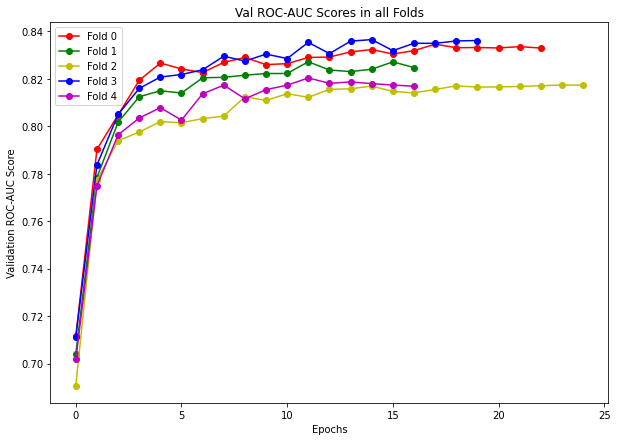

In [15]:
# Plot validation roc-auc scores for all 5 epochs from all 5 folds
plotFromFoldScores(fold_scores)